__Imports__

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

### __Data Preprocessing__

In [2]:
jokes_df = pd.read_excel('./data/jester-data-1.xls', sheet_name='jester-data-1-new')

In [3]:
jokes_df.index = [f'user_{i}' for i in range(len(jokes_df))]
jokes_df.columns = ['total'] + [f'J{i}' for i in range(1, 101)]

In [4]:
jokes_df = jokes_df.replace(99.0, np.nan)

In [5]:
jokes_df

,total,J1,J2,J3,J4,J5,J6,J7,J8,J9,...,J91,J92,J93,J94,J95,J96,J97,J98,J99,J100
user_0,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
user_1,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
user_2,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
user_3,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
user_4,100.0,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_24977,100.0,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
user_24978,91.0,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
user_24979,39.0,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_24980,37.0,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The sub-matrix including only __columns {5, 7, 8, 13, 15, 16, 17, 18, 19, 20} is dense__. Almost all users have rated those jokes.

In [6]:
sub_df = jokes_df.iloc[:, [5, 7, 8, 13, 15, 16, 17, 18, 19, 20]]

We employ __Collaborative Filtering__ using
### __Autoencoders for Collaborative Filtering__

In [7]:
# Copy your dense joke subset
data = sub_df.copy()

# Save mask of known ratings
mask = ~data.isna()

# Row-wise mean (only on rated jokes)
user_means = data.mean(axis=1)

# Center ratings: subtract mean where not NaN
normalized_data = data.sub(user_means, axis=0)

# Fill NaNs with 0 (neutral input for masked loss)
input_data = normalized_data.fillna(0).values.astype(np.float32)
inputs = torch.tensor(input_data)
masks = torch.tensor(mask.values.astype(np.float32))

In [8]:
def add_noise(x, mask, dropout_rate=0.3):
    noise_mask = (torch.rand(x.shape) > dropout_rate).float()
    noisy_input = x * noise_mask * mask  # only mask known values
    return noisy_input

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [10]:
def masked_mse_loss(preds, targets, mask):
    diff = (preds - targets) * mask
    mse = torch.sum(diff ** 2) / torch.sum(mask)
    return mse

def train_autoencoder_with_latent_dim(inputs, masks, latent_dim, num_epochs=100, verbose=True):
    model = Autoencoder(input_dim=inputs.shape[1], latent_dim=latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    losses = []

    for epoch in range(num_epochs):
        model.train()
        noisy_inputs = add_noise(inputs, masks, dropout_rate=0.3)
        preds = model(noisy_inputs)
        loss = masked_mse_loss(preds, inputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if verbose and epoch % 10 == 0:
            print(f"[Latent {latent_dim}] Epoch {epoch}, Loss: {loss.item():.4f}")

    return model, losses

In [11]:
latent_dims_to_test = [5, 10, 20, 50, 100]
results = {}

for dim in latent_dims_to_test:
    print(f"\n🔍 Training with latent dimension: {dim}")
    model, losses = train_autoencoder_with_latent_dim(inputs, masks, latent_dim=dim, num_epochs=200)
    results[dim] = {
        'model': model,
        'losses': losses
    }


🔍 Training with latent dimension: 5
[Latent 5] Epoch 0, Loss: 19.3333
[Latent 5] Epoch 10, Loss: 18.6902
[Latent 5] Epoch 20, Loss: 16.8072
[Latent 5] Epoch 30, Loss: 14.7621
[Latent 5] Epoch 40, Loss: 12.9597
[Latent 5] Epoch 50, Loss: 11.5090
[Latent 5] Epoch 60, Loss: 10.6033
[Latent 5] Epoch 70, Loss: 10.1132
[Latent 5] Epoch 80, Loss: 9.8477
[Latent 5] Epoch 90, Loss: 9.7322
[Latent 5] Epoch 100, Loss: 9.6737
[Latent 5] Epoch 110, Loss: 9.5649
[Latent 5] Epoch 120, Loss: 9.5486
[Latent 5] Epoch 130, Loss: 9.4990
[Latent 5] Epoch 140, Loss: 9.4477
[Latent 5] Epoch 150, Loss: 9.3995
[Latent 5] Epoch 160, Loss: 9.3744
[Latent 5] Epoch 170, Loss: 9.3125
[Latent 5] Epoch 180, Loss: 9.2887
[Latent 5] Epoch 190, Loss: 9.2548

🔍 Training with latent dimension: 10
[Latent 10] Epoch 0, Loss: 19.3144
[Latent 10] Epoch 10, Loss: 18.6299
[Latent 10] Epoch 20, Loss: 16.5631
[Latent 10] Epoch 30, Loss: 13.8907
[Latent 10] Epoch 40, Loss: 11.2218
[Latent 10] Epoch 50, Loss: 9.7384
[Latent 10] Ep

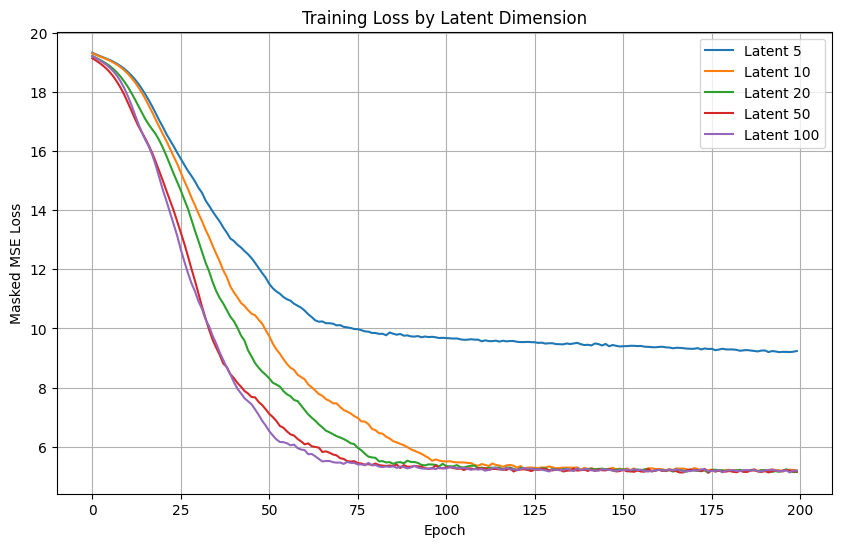

In [12]:
plt.figure(figsize=(10, 6))
for dim, result in results.items():
    plt.plot(result['losses'], label=f"Latent {dim}")
plt.xlabel("Epoch")
plt.ylabel("Masked MSE Loss")
plt.title("Training Loss by Latent Dimension")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.eval()
with torch.no_grad():
    reconstructed = model(inputs).numpy()

# Add user mean back (broadcasting works due to shape)
reconstructed += user_means.values[:, np.newaxis]

# Build prediction DataFrame
reconstructed_df = pd.DataFrame(reconstructed, index=sub_df.index, columns=sub_df.columns)

# Select rows with NaNs
rows_with_nans = sub_df[sub_df.isna().any(axis=1)]
reconstructed_nans = reconstructed_df.loc[rows_with_nans.index]

# Show original NaNs and predicted values
for idx in rows_with_nans.index[:5]:  # Limit output
    print(f"\nUser: {idx}")
    print("Original (NaNs):")
    print(rows_with_nans.loc[idx])
    print("Reconstructed (Predicted):")
    print(reconstructed_nans.loc[idx])


User: user_236
Original (NaNs):
J5      NaN
J7    -9.47
J8     3.69
J13   -3.88
J15   -9.32
J16   -9.76
J17   -1.94
J18   -0.10
J19   -9.27
J20   -7.04
Name: user_236, dtype: float64
Reconstructed (Predicted):
J5    -4.420520
J7    -9.577309
J8     3.977223
J13   -4.036678
J15   -9.176741
J16   -9.848001
J17   -1.549237
J18    0.071304
J19   -9.740912
J20   -8.031689
Name: user_236, dtype: float32

User: user_1185
Original (NaNs):
J5    -8.83
J7    -4.08
J8    -5.05
J13   -0.24
J15     NaN
J16   -2.86
J17   -3.83
J18   -8.69
J19   -6.02
J20   -8.74
Name: user_1185, dtype: float64
Reconstructed (Predicted):
J5    -8.642748
J7    -3.967462
J8    -4.628185
J13    0.115029
J15   -5.251134
J16   -3.619395
J17   -3.976566
J18   -8.262551
J19   -6.359088
J20   -8.979592
Name: user_1185, dtype: float32

User: user_1551
Original (NaNs):
J5     0.73
J7    -8.30
J8    -1.89
J13    0.73
J15   -2.04
J16     NaN
J17   -8.50
J18    1.21
J19    1.80
J20   -9.32
Name: user_1551, dtype: float64
Reconst

In [14]:
rows_with_nans

,J5,J7,J8,J13,J15,J16,J17,J18,J19,J20
user_236,NaN,-9.47,3.69,-3.88,-9.32,-9.76,-1.94,-0.10,-9.27,-7.04
user_1185,-8.83,-4.08,-5.05,-0.24,NaN,-2.86,-3.83,-8.69,-6.02,-8.74
user_1551,0.73,-8.30,-1.89,0.73,-2.04,NaN,-8.50,1.21,1.80,-9.32
user_1590,5.97,-2.52,-8.40,-7.04,-0.15,4.51,NaN,1.70,-3.98,3.25
user_2219,8.79,0.44,NaN,-6.75,-6.80,3.79,-9.51,2.82,8.50,-3.20
user_2689,0.44,2.96,NaN,8.11,3.45,3.30,4.51,2.96,2.86,2.91
user_2843,3.06,NaN,-4.42,8.54,-6.89,-9.27,1.12,4.51,-9.47,3.54
user_3459,8.74,8.64,-1.55,3.50,3.35,3.79,-1.60,0.68,NaN,4.13
user_3591,9.22,-0.87,-9.95,5.44,-9.61,-9.90,NaN,-9.95,4.56,7.18
user_3960,3.16,-7.82,-9.03,NaN,-6.31,-6.50,-1.89,-8.88,-5.19,1.31


In [15]:
reconstructed_nans

,J5,J7,J8,J13,J15,J16,J17,J18,J19,J20
user_236,-4.420520,-9.577309,3.977223,-4.036678,-9.176741,-9.848001,-1.549237,0.071304,-9.740912,-8.031689
user_1185,-8.642748,-3.967462,-4.628185,0.115029,-5.251134,-3.619395,-3.976566,-8.262551,-6.359088,-8.979592
user_1551,1.125598,-8.372243,-2.287669,1.121593,-1.826253,-3.639788,-8.540599,1.699724,1.578691,-9.331584
user_1590,5.784767,-2.098086,-8.868553,-7.476303,-0.615960,4.446896,-1.026070,2.464057,-2.434239,2.494848
user_2219,8.250414,1.347283,-1.171609,-6.616007,-7.379229,3.192458,-9.707367,3.843153,8.622927,-2.299401
user_2689,0.463096,3.125374,3.840842,8.376963,3.525093,2.496284,4.653165,3.089198,2.799563,2.788373
user_2843,3.897663,-0.472158,-3.332337,8.783118,-7.473067,-9.663634,1.366031,3.522444,-9.322645,2.417351
user_3459,8.654839,9.278942,-1.562751,3.163979,3.192238,2.506423,-1.581084,1.051682,4.168180,4.049260
user_3591,9.143358,0.184933,-10.094889,4.567668,-9.816248,-9.949260,-1.508453,-9.693624,5.274158,6.561765
user_3960,3.450935,-7.395039,-8.887571,-4.952863,-6.549150,-7.766493,-1.723402,-8.880928,-4.223559,1.257403
